In [ ]:
import os
import json
import requests

import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.data_transformers.disable_max_rows()

# Analysis
from scipy.stats import boxcox
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning & modeling
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    learning_curve,
    ShuffleSplit
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import shuffle

## 1. Call the API and store in JSON file

In [4]:
# Define the list of major cities in Massachusetts with their coordinates
cities = {
    "Boston": {"lat": "42.3601", "lon": "-71.0589"},
    "Worcester": {"lat": "42.2626", "lon": "-71.8023"},
    "Springfield": {"lat": "42.1015", "lon": "-72.5898"},
    "Lowell": {"lat": "42.6334", "lon": "-71.3162"},
    "Cambridge": {"lat": "42.3736", "lon": "-71.1097"},
    "Brockton": {"lat": "42.0834", "lon": "-71.0184"},
    "New Bedford": {"lat": "41.6362", "lon": "-70.9342"},
    "Fall River": {"lat": "41.7015", "lon": "-71.1550"},
    "Plymouth": {"lat": "41.9584", "lon": "-70.6673"},
    "Lynn": {"lat": "42.4668", "lon": "-70.9495"},
    "Quincy": {"lat": "42.2529", "lon": "-71.0023"},
    "Newton": {"lat": "42.3370", "lon": "-71.2092"},
    "Somerville": {"lat": "42.3876", "lon": "-71.0995"},
    "Lawrence": {"lat": "42.7070", "lon": "-71.1603"},
    "Framingham": {"lat": "42.2793", "lon": "-71.4162"}
}

url = "https://air-quality.p.rapidapi.com/history/airquality"
headers = {
    "x-rapidapi-key": "43f7651c54msha1845c116e7f838p1749f8jsn7f31d2420dff",
    "x-rapidapi-host": "air-quality.p.rapidapi.com"
}

filename = "MA_major_cities_air_quality.json"

# Load existing data if file exists
if os.path.exists(filename):
    with open(filename, "r", encoding="utf-8") as f:
        all_cities_data = json.load(f)
else:
    all_cities_data = {}

# Retrieve data for each city
for city, coords in cities.items():
    querystring = {"lat": coords["lat"], "lon": coords["lon"]}
    response = requests.get(url, headers=headers, params=querystring)
    if response.status_code == 200:
        new_data = response.json()
        if city in all_cities_data:
            # Combine new data with existing data
            combined = all_cities_data[city]["data"] + new_data["data"]
            # Use a dictionary to remove duplicates based on timestamp_utc
            unique = {}
            for record in combined:
                unique[record["timestamp_utc"]] = record
            all_cities_data[city]["data"] = list(unique.values())
        else:
            all_cities_data[city] = new_data
        print(f"{city} data download succeed")
    else:
        print(f"{city} data download failed, error code: {response.status_code}")

# Save the combined data to a JSON file
with open(filename, "w", encoding="utf-8") as f:
    json.dump(all_cities_data, f, indent=4, ensure_ascii=False)

print("All cities data saved to: ", filename)

Boston data download succeed
Worcester data download succeed
Springfield data download succeed
Lowell data download succeed
Cambridge data download succeed
Brockton data download succeed
New Bedford data download succeed
Fall River data download succeed
Plymouth data download succeed
Lynn data download succeed
Quincy data download succeed
Newton data download succeed
Somerville data download succeed
Lawrence data download succeed
Framingham data download succeed
All cities data saved to:  MA_major_cities_air_quality.json


## 2. Data Cleaning

In [32]:
# Load JSON file into a DataFrame
with open("MA_major_cities_air_quality.json", "r", encoding="utf-8") as f:
    all_cities = json.load(f)

# Combine data from all cities into a single DataFrame
# Add a new column 'city' to identify the city for each record
df_all = pd.concat(
    [pd.DataFrame(info["data"]).assign(city=city) for city, info in all_cities.items()],
    ignore_index=True
)

df_all.head()

aqi     co       datetime   no2    o3  pm10  pm25  so2  \
0   39   60.1  2025-03-06:03   3.0  84.3   6.0  5.00  2.0   
1   28  121.0  2025-03-06:02  34.0  60.8   9.5  5.00  1.0   
2   28  121.0  2025-03-06:01  23.0  61.2   6.0  5.00  1.0   
3   28  232.0  2025-03-06:00  31.5  61.4  11.7  5.33  1.0   
4   21  121.0  2025-03-05:23  42.0  37.2  17.0  5.00  1.0   

       timestamp_local        timestamp_utc          ts    city  
0  2025-03-05T22:00:00  2025-03-06T03:00:00  1741230000  Boston  
1  2025-03-05T21:00:00  2025-03-06T02:00:00  1741226400  Boston  
2  2025-03-05T20:00:00  2025-03-06T01:00:00  1741222800  Boston  
3  2025-03-05T19:00:00  2025-03-06T00:00:00  1741219200  Boston  
4  2025-03-05T18:00:00  2025-03-05T23:00:00  1741215600  Boston

In [33]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aqi              5025 non-null   int64  
 1   co               5025 non-null   float64
 2   datetime         5025 non-null   object 
 3   no2              5025 non-null   float64
 4   o3               5025 non-null   float64
 5   pm10             5025 non-null   float64
 6   pm25             5025 non-null   float64
 7   so2              5025 non-null   float64
 8   timestamp_local  5025 non-null   object 
 9   timestamp_utc    5025 non-null   object 
 10  ts               5025 non-null   int64  
 11  city             5025 non-null   object 
dtypes: float64(6), int64(2), object(4)
memory usage: 471.2+ KB


In [34]:
# Check missing values
df_all.isna().sum()

aqi                0
co                 0
datetime           0
no2                0
o3                 0
pm10               0
pm25               0
so2                0
timestamp_local    0
timestamp_utc      0
ts                 0
city               0
dtype: int64

In [35]:
# Check for outlier with IQR
air_cols = ['aqi','pm25','pm10','o3','co','so2','no2']

for col in air_cols:
    Q1 = df_all[col].quantile(0.25)
    Q3 = df_all[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    mask_outliers = (df_all[col] < lower_bound) | (df_all[col] > upper_bound)
    outliers = df_all[mask_outliers]
    
    print(f"{col} - lower_bound: {lower_bound:.2f}, upper_bound: {upper_bound:.2f}")
    print(f"{col} - Number of outlier: {len(outliers)}")


aqi - lower_bound: -6.00, upper_bound: 66.00
aqi - Number of outlier: 40
pm25 - lower_bound: -3.00, upper_bound: 13.00
pm25 - Number of outlier: 166
pm10 - lower_bound: -4.75, upper_bound: 22.05
pm10 - Number of outlier: 164
o3 - lower_bound: -18.00, upper_bound: 129.20
o3 - Number of outlier: 0
co - lower_bound: -147.00, upper_bound: 459.40
co - Number of outlier: 76
so2 - lower_bound: -2.00, upper_bound: 6.00
so2 - Number of outlier: 701
no2 - lower_bound: -39.25, upper_bound: 82.75
no2 - Number of outlier: 437


In [36]:
# Check for outlier with boxplot
df_long = df_all.melt(id_vars=["city", "timestamp_local"], value_vars=air_cols,
                      var_name="Variables", value_name="Value")

# Boxplot
air_boxplot = alt.Chart(df_long).mark_boxplot(extent=1.5).encode(
    x=alt.X('Variables:N', title='Variables', sort=air_cols),
    y=alt.Y('Value:Q', title='Value'),
    color=alt.Color('Variables:N', legend=None),
    tooltip=["Variables", "Value"]
).properties(
    width=600,
    height=300,
    title="Boxplot of Air Quality Data by Pollutant Variables"
)

air_boxplot


alt.Chart(...)

In [37]:
# Visualize the data using Altair
df_all['timestamp_local'] = pd.to_datetime(df_all['timestamp_local'])

air_charts = []
for vars in air_cols:
    chart = alt.Chart(df_all).mark_line(point=True).encode(
        x=alt.X('timestamp_local:T', title='Time'),
        y=alt.Y(f'{vars}:Q', title=vars.upper()),
        color=alt.Color('city:N', title='City'),
        tooltip=['city', 'timestamp_local:T', vars]
    ).properties(
        width=1000,
        height=150,
        title=f'{vars.upper()} Trend of Major Cities in Massachusetts'
    )
    air_charts.append(chart)

air_chart_combined = alt.vconcat(*air_charts).resolve_scale(y='independent')
air_chart_combined

alt.VConcatChart(...)

 Summary of Outliers:

1. Outlier Distribution Characteristics:
CO, NO₂, SO₂: A large number of high values fall above the IQR upper bound, indicating a clear long-tail distribution (CO: 500+ records; NO₂ and SO₂: 200+ each).
PM₂.₅, PM₁₀: Some high values exist, but fewer in comparison.
O₃: No outliers detected, suggesting a more concentrated distribution.

2. Reasons for High Number of Outliers:
High values may represent real pollution spikes, caused by episodic emissions from traffic or industrial sources, rather than data errors.

3. Transformation:
Apply log or Box-Cox transformations to long-tailed variables like CO and NO₂ to smooth distributions and improve model performance.
Further Visualization: Use QQ-plots to compare data distributions before and after transformation, assessing improvements in normality.

## Correlation Analysis and Principal Component Analysis (PCA)

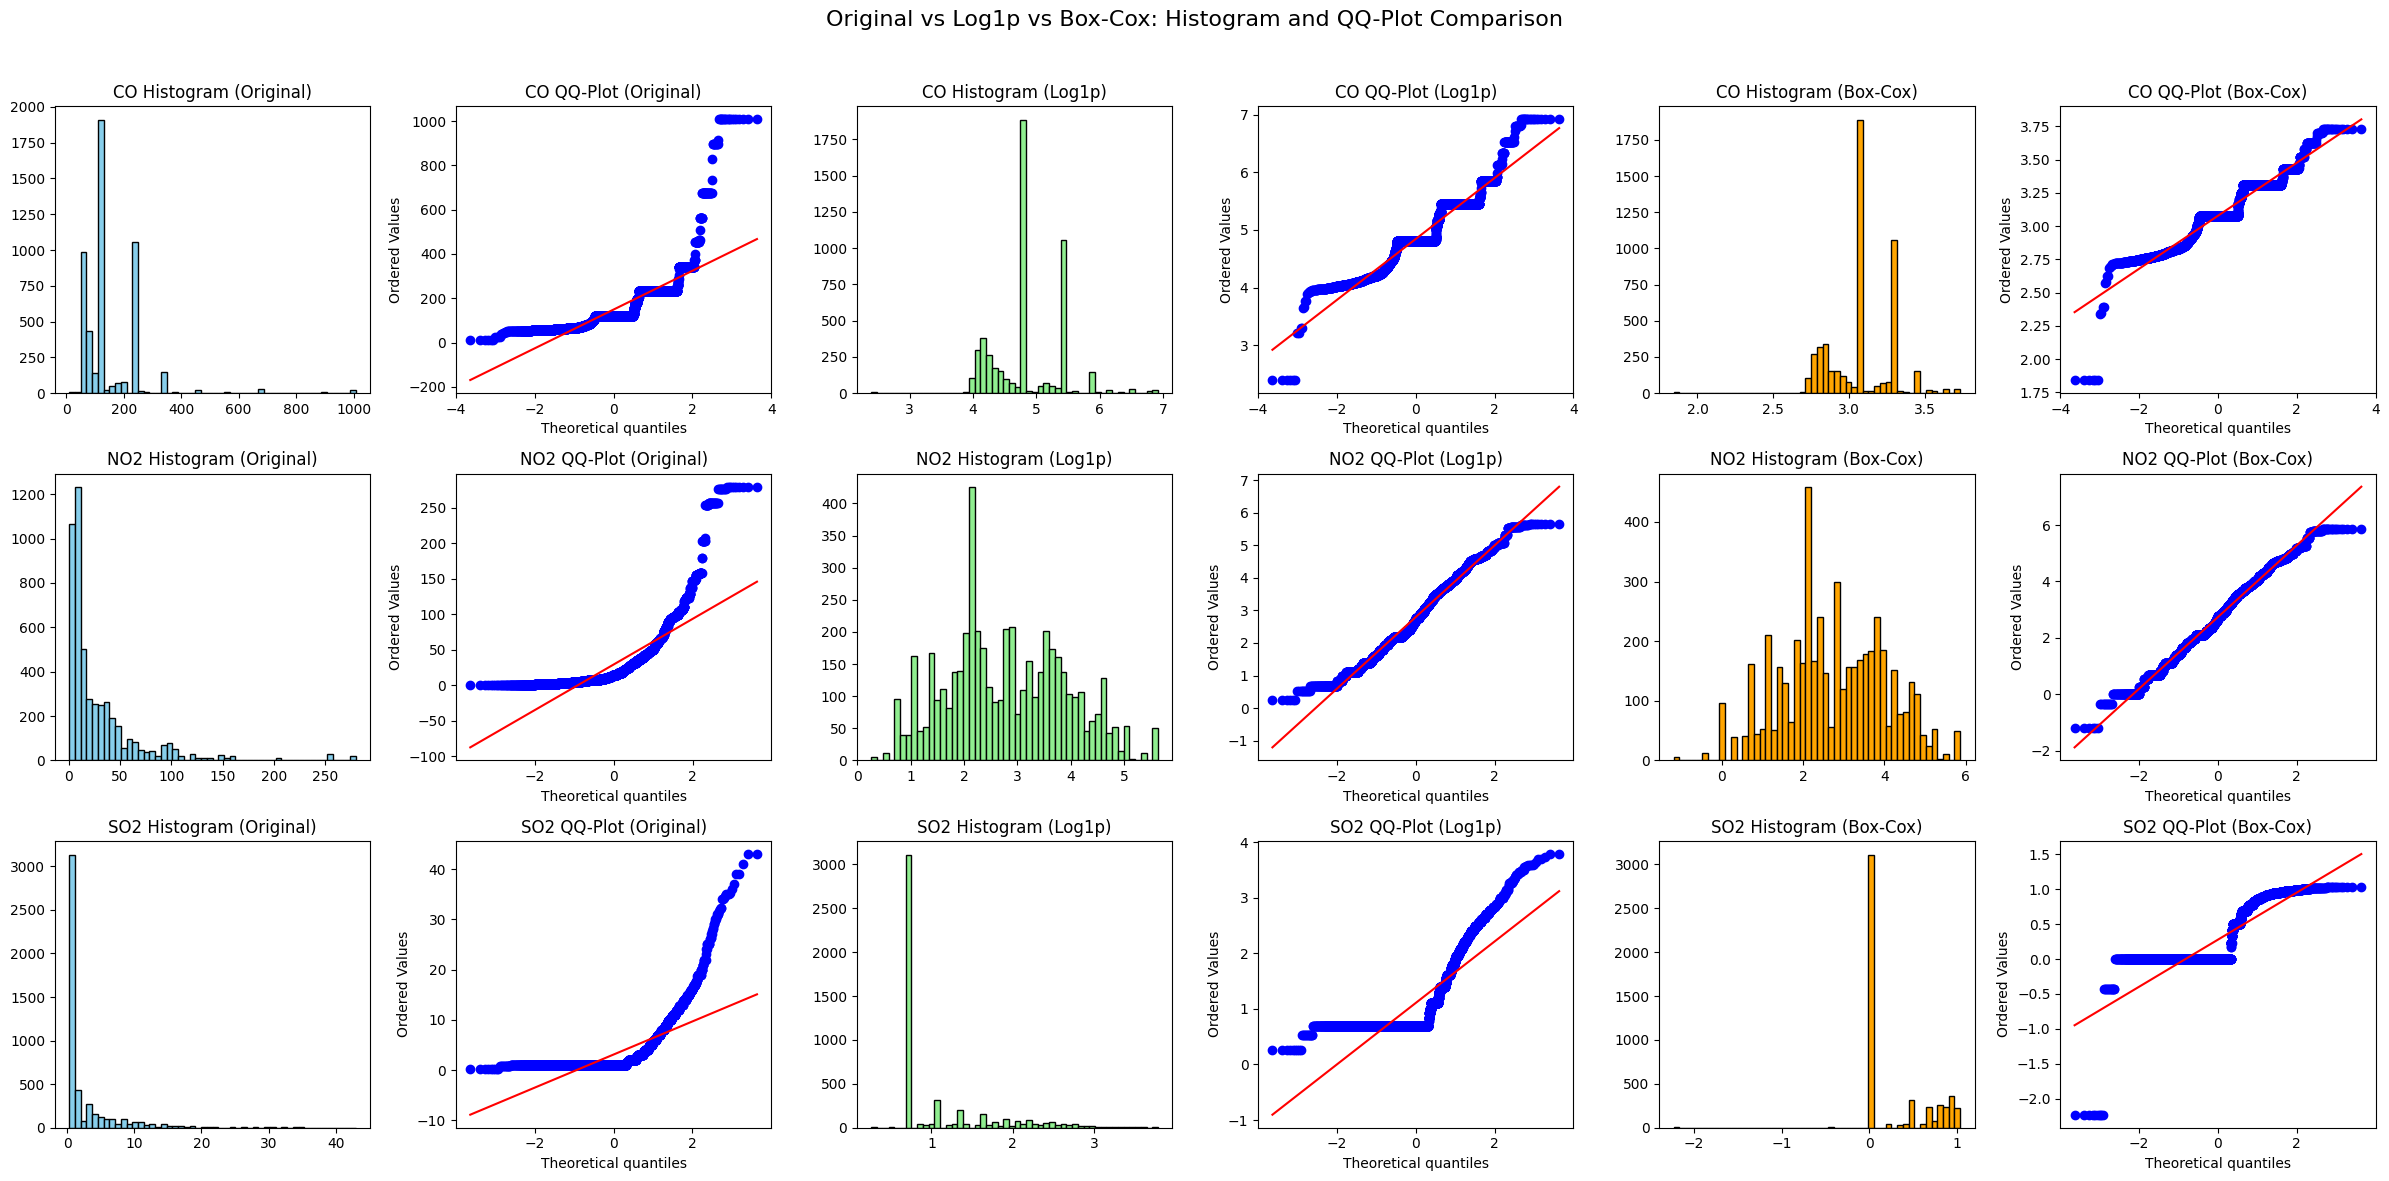

In [38]:
# Plot QQ-Plot and Histogram for long-tailed variables (Original vs Log1p vs Box-Cox)
long_tailed_vars = ["co", "no2", "so2"]

# Hist + QQ for Original vs Log1p vs Box-Cox
fig, axes = plt.subplots(len(long_tailed_vars), 6, figsize=(24, 12))
fig.suptitle("Original vs Log1p vs Box-Cox: Histogram and QQ-Plot Comparison", fontsize=16)

for i, var in enumerate(long_tailed_vars):
    # get positive values for Box-Cox transformation
    data = pd.to_numeric(df_all[var], errors='coerce').dropna()
    data = data[data > 0]

    # log1p and Box-Cox transformations
    log_data = np.log1p(data)
    boxcox_data, _ = stats.boxcox(data)

    # Histogram - Origianl
    axes[i, 0].hist(data, bins=50, color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f"{var.upper()} Histogram (Original)")

    # QQ-Plot - Origianl
    stats.probplot(data, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f"{var.upper()} QQ-Plot (Original)")

    # Histogram - Log1p
    axes[i, 2].hist(log_data, bins=50, color='lightgreen', edgecolor='black')
    axes[i, 2].set_title(f"{var.upper()} Histogram (Log1p)")

    # QQ-Plot - Log1p
    stats.probplot(log_data, dist="norm", plot=axes[i, 3])
    axes[i, 3].set_title(f"{var.upper()} QQ-Plot (Log1p)")

    # Histogram - Box-Cox
    axes[i, 4].hist(boxcox_data, bins=50, color='orange', edgecolor='black')
    axes[i, 4].set_title(f"{var.upper()} Histogram (Box-Cox)")

    # QQ-Plot - Box-Cox
    stats.probplot(boxcox_data, dist="norm", plot=axes[i, 5])
    axes[i, 5].set_title(f"{var.upper()} QQ-Plot (Box-Cox)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Summary of Transformation:
1. CO:
     - Box-Cox: Histogram is more symmetrical; QQ-Plot closely aligns with the straight line.
     - Log1p: Significant improvement, but heavy tail still deviates.

    Result: Box-Cox	is more effective in reducing long tail; QQ-Plot is nearly linear.

2. NO₂:
     - Box-Cox: QQ-Plot is straighter; distribution approximates normality.
     - Log1p: Some improvement, but slightly weaker than Box-Cox.

    Result: Box-Cox performs better than Log1p, especially in handling the tail.

3. SO₂:
     - Box-Cox: Greatly reduces the long tail; distribution is more concentrated.
     - Log1p: Less effective; tail deviation remains.
     
    Result: Box-Cox results in a more normal-like distribution.

In [39]:
# Split train and test sets base on time
df_all["timestamp_local"] = pd.to_datetime(df_all["timestamp_local"])
df_all = df_all.sort_values("timestamp_local")

split_idx = int(len(df_all) * 0.8)
df_train = df_all.iloc[:split_idx].copy()
df_test = df_all.iloc[split_idx:].copy()

In [40]:
# Apply Box-Cox transformation to long-tailed variables
long_tailed_vars = ["co", "no2", "so2"]
for var in long_tailed_vars:
    for df_part in [df_train, df_test]:
        df_part[var] = pd.to_numeric(df_part[var], errors='coerce')
    # Fit Box-Cox only on training set
    data_train = df_train[var].copy()
    data_train[data_train <= 0] = np.nan
    transformed_train, lmbda = boxcox(data_train.dropna())
    df_train[f"{var}_boxcox"] = np.nan
    df_train.loc[data_train.dropna().index, f"{var}_boxcox"] = transformed_train

    # Apply to test set
    data_test = df_test[var].copy()
    data_test[data_test <= 0] = np.nan
    transformed_test = boxcox(data_test.dropna(), lmbda=lmbda)
    df_test[f"{var}_boxcox"] = np.nan
    df_test.loc[data_test.dropna().index, f"{var}_boxcox"] = transformed_test

In [41]:
# Standardize the scale variables
scale_vars = ["aqi", "pm25", "pm10", "o3"]
scaler = StandardScaler()
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

scaled_train = scaler.fit_transform(df_train[scale_vars])
scaled_test = scaler.transform(df_test[scale_vars])

for i, var in enumerate(scale_vars):
    df_train_scaled[f"{var}_scaled"] = scaled_train[:, i]
    df_test_scaled[f"{var}_scaled"] = scaled_test[:, i]

print(f"Length of train set: {len(df_train_scaled)}")
print(f"Length of test set: {len(df_test_scaled)}")

Length of train set: 4020
Length of test set: 1005


In [42]:
# Feature engineering (same for both)
for df in [df_train_scaled, df_test_scaled]:
    df['hour'] = df["timestamp_local"].dt.hour
    df['dayofweek'] = df["timestamp_local"].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    df.drop(columns=["aqi", "co", "no2", "so2", "pm25", "pm10", "o3", 
                     "datetime", "timestamp_local", "timestamp_utc", "ts"], errors="ignore", inplace=True)

    df.dropna(inplace=True)

    print(f"Remaining rows in dataset: {len(df)}")

    df.reset_index(drop=True, inplace=True)

# One-hot encoding for city
df_train_model = pd.get_dummies(df_train_scaled, columns=["city"], drop_first=True)
df_test_model = pd.get_dummies(df_test_scaled, columns=["city"], drop_first=True)

Remaining rows in dataset: 3975
Remaining rows in dataset: 994


In [43]:
df_train_model.head()

co_boxcox  no2_boxcox  so2_boxcox  aqi_scaled  pm25_scaled  pm10_scaled  \
0   3.217651    2.752322    0.000000   -1.138405    -0.244589    -0.638301   
1   2.760051    1.169914    0.647895    0.466012     0.254773    -0.320208   
2   3.217651    2.752322    0.000000   -1.138405    -0.244589    -0.638301   
3   3.217651    2.752322    0.000000   -1.138405    -0.244589    -0.638301   
4   2.762572    1.279539    0.687674    0.550455    -0.157398    -0.588076   

   o3_scaled  hour  dayofweek  is_weekend  ...  city_Lawrence  city_Lowell  \
0  -1.031994    23          6           1  ...          False        False   
1   0.991069    23          6           1  ...          False        False   
2  -1.031994    23          6           1  ...          False        False   
3  -1.031994    23          6           1  ...          False        False   
4   1.042943    23          6           1  ...          False        False   

   city_Lynn  city_New Bedford  city_Newton  city_Plymouth  city_Quincy  \
0      False             False        False          False        False   
1      False             False        False          False        False   
2      False             False        False          False        False   
3       True             False        False          False        False   
4      False             False        False          False        False   

   city_Somerville  city_Springfield  city_Worcester  
0            False             False           False  
1            False             False            True  
2            False             False           False  
3            False             False           False  
4            False              True           False  

[5 rows x 24 columns]

In [44]:
df_train_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3975 entries, 0 to 3974
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   co_boxcox         3975 non-null   float64
 1   no2_boxcox        3975 non-null   float64
 2   so2_boxcox        3975 non-null   float64
 3   aqi_scaled        3975 non-null   float64
 4   pm25_scaled       3975 non-null   float64
 5   pm10_scaled       3975 non-null   float64
 6   o3_scaled         3975 non-null   float64
 7   hour              3975 non-null   int32  
 8   dayofweek         3975 non-null   int32  
 9   is_weekend        3975 non-null   int64  
 10  city_Brockton     3975 non-null   bool   
 11  city_Cambridge    3975 non-null   bool   
 12  city_Fall River   3975 non-null   bool   
 13  city_Framingham   3975 non-null   bool   
 14  city_Lawrence     3975 non-null   bool   
 15  city_Lowell       3975 non-null   bool   
 16  city_Lynn         3975 non-null   bool   


In [45]:
df_test_model.head()

co_boxcox  no2_boxcox  so2_boxcox  aqi_scaled  pm25_scaled  pm10_scaled  \
0   2.999685    4.171164    0.000000   -0.462861     0.283837     1.370705   
1   2.999685    4.171164    0.000000   -0.462861     0.283837     1.370705   
2   2.999685    4.171164    0.000000   -0.462861     0.283837     1.370705   
3   2.999685    4.171164    0.000000   -0.462861     0.283837     1.370705   
4   2.856531    2.700484    0.990836    0.212683     0.812262     0.366202   

   o3_scaled  hour  dayofweek  is_weekend  ...  city_Lawrence  city_Lowell  \
0  -1.442658     4          4           0  ...          False        False   
1  -1.442658     4          4           0  ...          False        False   
2  -1.442658     4          4           0  ...          False        False   
3  -1.442658     4          4           0  ...          False        False   
4   0.269164     4          4           0  ...          False        False   

   city_Lynn  city_New Bedford  city_Newton  city_Plymouth  city_Quincy  \
0       True             False        False          False        False   
1      False             False        False          False        False   
2      False             False        False          False        False   
3      False             False        False          False        False   
4      False             False        False          False        False   

   city_Somerville  city_Springfield  city_Worcester  
0            False             False           False  
1             True             False           False  
2            False             False           False  
3            False             False           False  
4            False             False            True  

[5 rows x 24 columns]

In [46]:
# Align columns
X_train = df_train_model.drop(columns=["aqi_scaled"])
y_train = df_train_model["aqi_scaled"]
X_test = df_test_model.drop(columns=["aqi_scaled"])
y_test = df_test_model["aqi_scaled"]

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

## 3. Data Modeling

In [51]:
# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1),
    "Lasso": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0,
                             objective='reg:squarederror', tree_method='hist', device='cpu', random_state=42),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5, weights='uniform')
}

In [52]:
# Use Pipeline & GridSearchCV to train and evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    results[name] = {
        "MAE (Test)": mean_absolute_error(y_test, y_pred_test),
        "RMSE (Test)": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "R² (Train)": r2_score(y_train, y_pred_train),
        "R² (Test)": r2_score(y_test, y_pred_test)
    }

# Turn the result to dataframe
results_df = pd.DataFrame(results).T
results_df.index.name = "Model"

print("\nModel Performance (Train/Test):")
print(results_df)

Training Linear Regression...
Training Ridge...
Training Lasso...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training KNN Regressor...

Model Performance (Train/Test):
                   MAE (Test)  RMSE (Test)  R² (Train)  R² (Test)
Model                                                            
Linear Regression    0.367921     0.439810    0.851041   0.682531
Ridge                0.367715     0.439581    0.851041   0.682862
Lasso                0.365939     0.437664    0.850999   0.685622
Random Forest        0.020175     0.052850    0.998913   0.995416
Gradient Boosting    0.023036     0.046296    0.999937   0.996482
XGBoost              0.035352     0.092462    0.999867   0.985969
KNN Regressor        0.520981     0.681278    0.934995   0.238238


Summary:

 - Linear models performed significantly worse than non-linear models.
 - Applying transformations such as log and boxcox led to noticeable performance improvements, confirming the presence of non-linear relationships.
 - Since the relationship between AQI and pollutant levels is typically complex and non-linear, using models like XGBoost, Gradient Boosting (GBDT), and Random Forest will be an appropriate and effective choice.

However, the redult shows Random Forest, Gradient Boosting, and XGBoost has irrregular R2 value that larger than 0.99, which may cause by data leak or overfitting. Next step, use feature importance analysis to analzye.

## Feature Importance Analysis Check

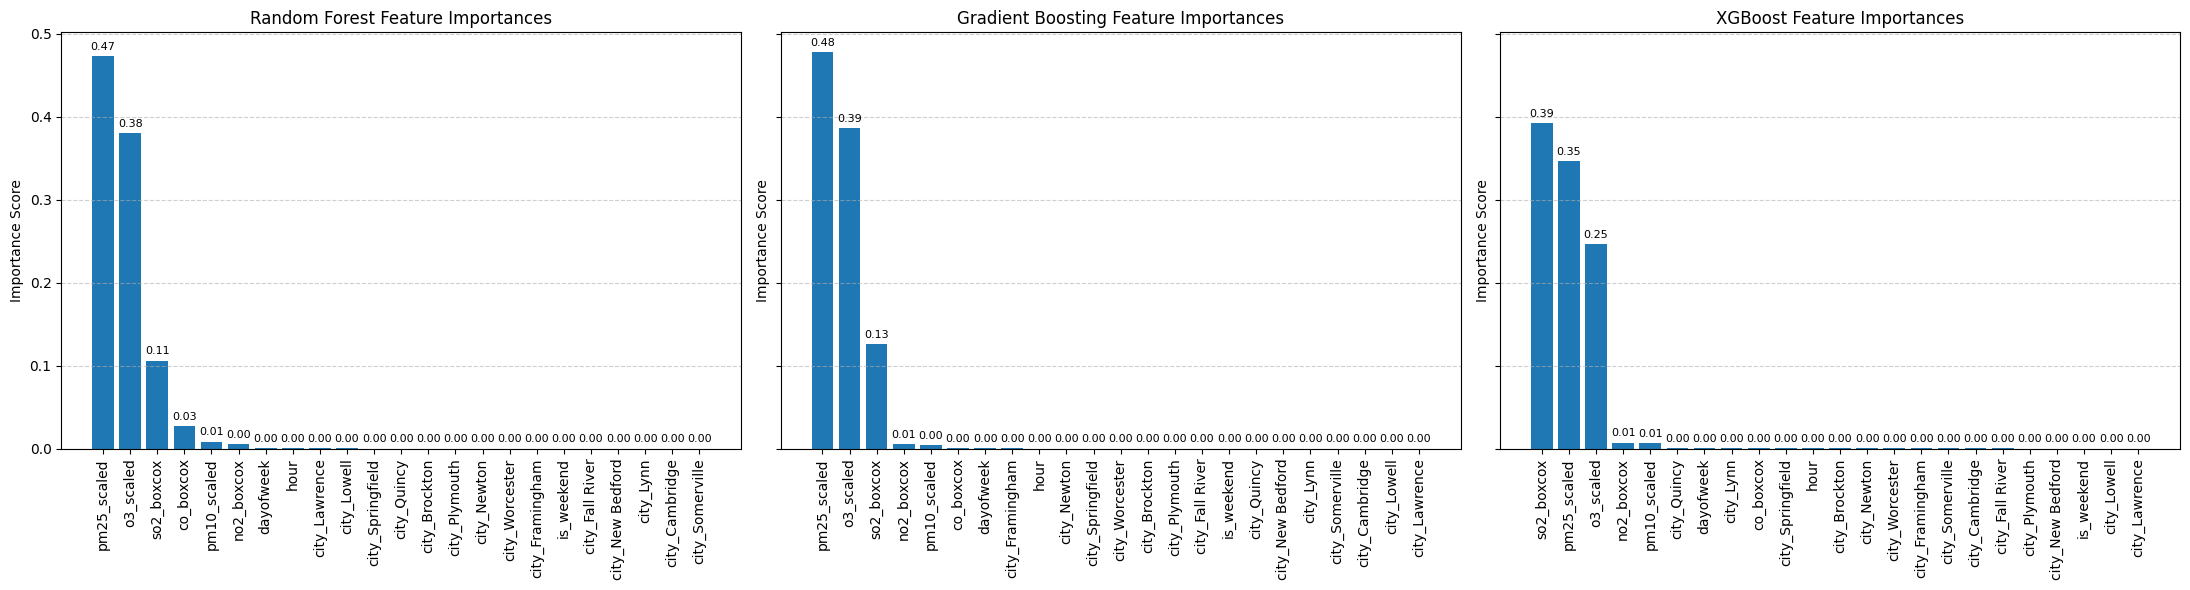

In [53]:
# Check Feature Importance for Random Forest, Gradient Boosting, and XGBoost

X = X_train.copy()
y = y_train.copy()
feature_names = X.columns

FIA_models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0,
                             objective='reg:squarederror', tree_method='hist', device='cpu', random_state=42)
}

# Plot feature importance
def plot_feature_importance(model, model_name, ax):
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_features = feature_names[indices]
    sorted_importances = importances[indices]

    bars = ax.bar(range(len(importances)), sorted_importances)
    ax.set_xticks(range(len(importances)))
    ax.set_xticklabels(sorted_features, rotation=90)
    ax.set_title(f"{model_name} Feature Importances")
    ax.set_ylabel("Importance Score")
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Label bars with importance scores
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, color='black')

# Subplot for feature importance
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6), sharey=True)

for ax, (name, model) in zip(axes, FIA_models.items()):
    plot_feature_importance(model, name, ax)

plt.tight_layout()
plt.show()

Summary:

Across all three models—Random Forest, Gradient Boosting, and XGBoost—the top features influencing AQI prediction are consistently: pm25_scaled, o3_scaled, and so2_boxcox.

 - Random Forest places extremely high weight on pm25_scaled, indicating a strong preference for high-dimensional fitting and downplaying time or city-related features.
 - Gradient Boosting shows a similar pattern but is slightly more concentrated, relying even more heavily on the top three features.
 - XGBoost distributes feature importance more evenly, with so2_boxcox contributing more significantly compared to the other two models.

Conclusion:
These models rely heavily on PM2.5 and O₃ to predict AQI, which aligns with their strong R² scores observed in previous evaluations, which confirm that these pollutants are key drivers in AQI estimation.

In [58]:
# A/B Test for for Random Forest, Gradient Boosting, and XGBoost
# Feature Ablation Study (A vs. B with/without key features)

# Split the data into training and testing sets for A/B test
key_var_rm = ["pm25_scaled", "o3_scaled"]

X_train_A = X_train.copy()
X_test_A = X_test.copy()

X_train_B = X_train.drop(columns=key_var_rm)
X_test_B = X_test.drop(columns=key_var_rm)


def evaluate_models(X_train, X_test, y_train, y_test):
    results = {}
    for name, model in FIA_models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': r2_score(y_test, y_pred)
        }
    return pd.DataFrame(results).T

# Team A: Include pm25_scaled & o3_scaled
print("\n Team A (Include pm25_scaled & o3_scaled) result：")
results_A = evaluate_models(X_train_A, X_test_A, y_train, y_test)
print(results_A)

# Team B: Exclude pm25_scaled & o3_scaled
print("\n Team B (Exclude pm25_scaled & o3_scaled) result：")
results_B = evaluate_models(X_train_B, X_test_B, y_train, y_test)
print(results_B)


 Team A (Include pm25_scaled & o3_scaled) result：
                        MAE      RMSE        R2
Random Forest      0.020175  0.052850  0.995416
Gradient Boosting  0.023036  0.046296  0.996482
XGBoost            0.035352  0.092462  0.985969

 Team B (Exclude pm25_scaled & o3_scaled) result：
                        MAE      RMSE        R2
Random Forest      0.474659  0.668755  0.265986
Gradient Boosting  0.508251  0.667087  0.269642
XGBoost            0.519112  0.682406  0.235713


R2 significantly dropped after exclude the pm25_scaled and o3_scaled.

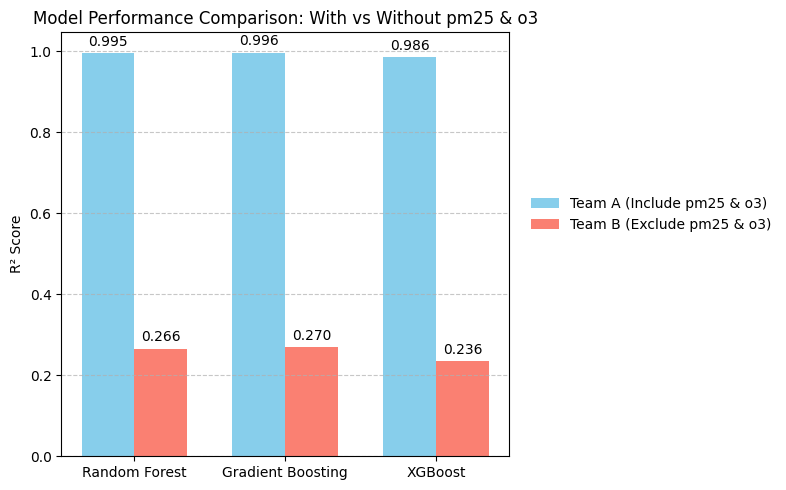

In [61]:
# Visualize the R² scores for Team A and Team B

model_names = ["Random Forest", "Gradient Boosting", "XGBoost"]

# Team A R2 scores (include pm25 & o3)
mae_a = results_A.loc[model_names, "MAE"].values
rmse_a = results_A.loc[model_names, "RMSE"].values
r2_a = results_A.loc[model_names, "R2"].values

# Team B R2 scores (exclude pm25 & o3)
mae_b = results_B.loc[model_names, "MAE"].values
rmse_b = results_B.loc[model_names, "RMSE"].values
r2_b = results_B.loc[model_names, "R2"].values

x = np.arange(len(model_names))
width = 0.35  

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8,5))
bars_a = ax.bar(x - width/2, r2_a, width, label='Team A (Include pm25 & o3)', color='skyblue')
bars_b = ax.bar(x + width/2, r2_b, width, label='Team B (Exclude pm25 & o3)', color='salmon')

# Label the bars with R2 scores
for bar in bars_a + bars_b:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_ylabel('R² Score')
ax.set_title('Model Performance Comparison: With vs Without pm25 & o3')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='lower left', bbox_to_anchor=(1.02, 0.5), frameon=False)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Combine scaled train and test data for correlation and PCA analysis
cor_var = ['aqi_scaled', 'co_boxcox', 'no2_boxcox', 'so2_boxcox', 'pm25_scaled', 'pm10_scaled', 'o3_scaled']

df_processed = pd.concat([df_train_scaled[cor_var], df_test_scaled[cor_var]], axis=0)

In [ ]:
# Check correlation between aqi, pm25 and o3
df_processed[cor_var].corr()

aqi_scaled  co_boxcox  no2_boxcox  so2_boxcox  pm25_scaled  \
aqi_scaled     1.000000  -0.382168   -0.264152    0.540753     0.700121   
co_boxcox     -0.382168   1.000000    0.741170   -0.429049    -0.028153   
no2_boxcox    -0.264152   0.741170    1.000000   -0.317326     0.175998   
so2_boxcox     0.540753  -0.429049   -0.317326    1.000000     0.281182   
pm25_scaled    0.700121  -0.028153    0.175998    0.281182     1.000000   
pm10_scaled    0.351217   0.220401    0.357294    0.009877     0.705157   
o3_scaled      0.588357  -0.620353   -0.640882    0.442807     0.018259   

             pm10_scaled  o3_scaled  
aqi_scaled      0.351217   0.588357  
co_boxcox       0.220401  -0.620353  
no2_boxcox      0.357294  -0.640882  
so2_boxcox      0.009877   0.442807  
pm25_scaled     0.705157   0.018259  
pm10_scaled     1.000000  -0.228881  
o3_scaled      -0.228881   1.000000

In [66]:
# Draw heatmap for correlation
corr_matrix = df_processed[cor_var].corr().round(3)

corr_df = corr_matrix.reset_index().melt(id_vars="index")
corr_df.columns = ["Variable1", "Variable2", "Correlation"]

# Plot heatmap
heatmap = alt.Chart(corr_df).mark_rect().encode(
    x=alt.X("Variable1:O", title=None),
    y=alt.Y("Variable2:O", title=None),
    color=alt.Color("Correlation:Q", scale=alt.Scale(scheme="redblue"), legend=alt.Legend(title="Correlation")),
    tooltip=["Variable1", "Variable2", "Correlation"]
).properties(
    width=400,
    height=400,
    title="Correlation Matrix Heatmap"
)

# Add labels
text = alt.Chart(corr_df).mark_text(baseline='middle').encode(
    x="Variable1:O",
    y="Variable2:O",
    text="Correlation:Q",
    color=alt.condition(
        "datum.Correlation > 0.5 || datum.Correlation < -0.5",
        alt.value("white"),
        alt.value("black")
    )
)

cor_heatmap = (heatmap + text).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(fontSize=16)

cor_heatmap

alt.LayerChart(...)

Summary: 

 - aqi_scaled vs pm25_scaled: Correlation = 07 indicate strong relationship, confirming PM2.5 as a key component of AQI.
 - aqi_scaled vs o3_scaled: Correlation = 0.599 indicate highly influential on AQI.
 - pm10_scaled vs pm25_scaled: Correlation = 0.698 indicate high correlation suggests potential feature redundancy between the two particulate measures.
 - co_boxcox, no2_boxcox: Show moderate correlations with other variables, but not as strong as PM2.5 and O3.

Conclusion:

Choosing pm25_scaled and o3_scaled as main variables for A/B testing is fully justified. However, their dominance in the models suggests it may be beneficial to encourage the model to consider a broader range of features for more balanced learning.

### Principal Component Analaysis (PCA)

In [67]:
# Calculate PCA

# Drop na and scale the data
df_pca = df_processed.dropna()
scaled_data = StandardScaler().fit_transform(df_pca)

# PCA calculation
pca = PCA()
pca_result = pca.fit(scaled_data)

explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

# PCA cumulative explained variance to dataframe
pca_cum_df = pd.DataFrame({
    "Component": range(1, len(cumulative_var)+1),
    "Cumulative Explained Variance": cumulative_var
})

In [68]:
# Plot cumulative explained variance by PCA

# Plot cumulative explained variance
line = alt.Chart(pca_cum_df).mark_line(point=True).encode(
    x=alt.X("Component:O", title="Number of Principal Components"),
    y=alt.Y("Cumulative Explained Variance:Q", scale=alt.Scale(domain=[0, 1])),
    tooltip=["Component", "Cumulative Explained Variance"]
)

# Add 90% threshold line
threshold = alt.Chart(pd.DataFrame({
    "y": [0.9]
})).mark_rule(strokeDash=[4, 4], color="red").encode(y="y")

# Add label for 90% threshold
label = alt.Chart(pd.DataFrame({
    "y": [0.9],
    "label": ["90% Threshold"]
})).mark_text(align="left", dx=5, dy=-5, color="red").encode(
    x=alt.value(1),
    y="y:Q",
    text="label"
)

# Combine the line chart, threshold line, and label
PCA_chart = (line + threshold + label).properties(
    title="Cumulative Explained Variance by PCA",
    width=600,
    height=400
).configure_title(fontSize=16)

PCA_chart

alt.LayerChart(...)

In [33]:
# PCA components
pca_components = pd.DataFrame(pca.components_.T, 
                              columns=[f"PC{i+1}" for i in range(len(cor_var))],
                              index=cor_var)

print("\nPCA components:")
display(pca_components.round(3))


PCA components:


PC1    PC2    PC3    PC4    PC5    PC6    PC7
co_boxcox   -0.466  0.175  0.272  0.501  0.340 -0.550 -0.095
no2_boxcox  -0.427  0.307  0.341  0.255 -0.285  0.678  0.040
so2_boxcox   0.397  0.121  0.830 -0.298  0.215 -0.016 -0.058
pm25_scaled  0.155  0.602 -0.116 -0.074 -0.450 -0.244 -0.577
pm10_scaled -0.050  0.585 -0.314 -0.258  0.656  0.230  0.085
o3_scaled    0.484 -0.122 -0.090  0.618  0.288  0.320 -0.419
aqi_scaled   0.426  0.376 -0.027  0.376 -0.201 -0.155  0.686

Summary:

The first four principal components (PC1–PC4) explain approximately 91% of the total variance, while the remaining components contribute very little additional information.

Thus, select the top four components to reduce feature dimensionality while retaining key information. These components can be used to replace the original seven pollution variables, helping to simplify the model, reduce redundancy, and mitigate overfitting.

In [34]:
# Get PC1-4 for train and test sets
X_pca_all = pca.fit_transform(scaled_data)

# Match index
valid_index = df_processed.dropna().index
X_pca_df = pd.DataFrame(X_pca_all[:, :4], columns=["PC1", "PC2", "PC3", "PC4"], index=valid_index)

# Get Train/Test PCA
X_train_pca = X_pca_df.loc[df_train_scaled.index.intersection(valid_index)].to_numpy()
X_test_pca = X_pca_df.loc[df_test_scaled.index.intersection(valid_index)].to_numpy()

# Y PCA
y_train_pca = y_train.loc[X_pca_df.index.intersection(df_train_scaled.index)].to_numpy()
y_test_pca = y_test.loc[X_pca_df.index.intersection(df_test_scaled.index)].to_numpy()

In [ ]:
# Train set fot PCA
df_train_clean = df_train_scaled[cor_var].dropna()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train_clean)

# Train PCA
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)

# Tset set for PCA
df_test_clean = df_test_scaled[cor_var].dropna()
X_test_scaled = scaler.transform(df_test_clean)
X_test_pca = pca.transform(X_test_scaled)

# Align y_train and y_test with the cleaned DataFrame
y_train_pca = y_train.loc[df_train_clean.index].to_numpy()
y_test_pca = y_test.loc[df_test_clean.index].to_numpy()

In [38]:
def evaluate_models(X_train, X_test, y_train, y_test, models):
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        results[name] = {
            "MAE (Test)": mean_absolute_error(y_test, y_pred_test),
            "RMSE (Test)": np.sqrt(mean_squared_error(y_test, y_pred_test)),
            "R² (Train)": r2_score(y_train, y_pred_train),
            "R² (Test)": r2_score(y_test, y_pred_test)
        }

    return pd.DataFrame(results).T


# Evaluate results with PCA
results_pca = evaluate_models(X_train_pca, X_test_pca, y_train.reset_index(drop=True), y_test.reset_index(drop=True), models)

results_pca_full = evaluate_models(X_train_pca, X_test_pca, y_train_pca, y_test_pca, models)
display(results_pca_full)


MAE (Test)  RMSE (Test)  R² (Train)  R² (Test)
Random Forest        0.160158     0.228063    0.998755   0.914635
Gradient Boosting    0.176779     0.241126    0.999802   0.904576
XGBoost              0.147247     0.200769    0.998221   0.933845

In [69]:
# Combine undersampling with PCA

# Undersampling threshold
threshold_pm25 = df_train_scaled['pm25_scaled'].quantile(0.75)
threshold_o3 = df_train_scaled['o3_scaled'].quantile(0.75)
threshold_so2 = df_train_scaled['so2_boxcox'].quantile(0.75)

# Define dominated samples
dominated = df_train_scaled[
    (df_train_scaled['pm25_scaled'] > threshold_pm25) |
    (df_train_scaled['o3_scaled'] > threshold_o3) |
    (df_train_scaled['so2_boxcox'] > threshold_so2)
]

# Define non-dominated samples
non_dominated = df_train_scaled.drop(dominated.index)

# Undersampleing dominated samples
dominated_sampled = dominated.sample(frac=0.4, random_state=42) # 40% of dominated samples

# # Combine non-dominated and undersampled dominated samples
df_train_resampled = pd.concat([non_dominated, dominated_sampled]).sort_index()

# y_train resampled
y_train_resampled = y_train.loc[df_train_resampled.index]

# PCA 
# cor_var = ['co_boxcox', 'no2_boxcox', 'so2_boxcox', 'pm25_scaled', 'pm10_scaled', 'o3_scaled', 'aqi_scaled']

# Standadize resampled train set
df_train_clean = df_train_resampled[cor_var].dropna()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train_clean)
y_train_final = y_train_resampled.loc[df_train_clean.index].to_numpy()

# PCA for resampled train set
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)

# PCC for test set
df_test_clean = df_test_scaled[cor_var].dropna()
X_test_scaled = scaler.transform(df_test_clean)
X_test_pca = pca.transform(X_test_scaled)
y_test_final = y_test.loc[df_test_clean.index].to_numpy()

# Evaluate models with PCA and resampled data
def evaluate_models(X_train, X_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        results[name] = {
            "MAE (Test)": mean_absolute_error(y_test, y_pred_test),
            "RMSE (Test)": np.sqrt(mean_squared_error(y_test, y_pred_test)),
            "R² (Train)": r2_score(y_train, y_pred_train),
            "R² (Test)": r2_score(y_test, y_pred_test)
        }
    return pd.DataFrame(results).T

# Model list
PCA_models = {
    "Random Forest (Conservative)": RandomForestRegressor(
        n_estimators=100,         # reduce the number of trees
        max_depth=5,              # limit the depth of trees
        min_samples_leaf=5,       # 5 samples per leaf
        random_state=42
    ),

    "Gradient Boosting (Conservative)": GradientBoostingRegressor(
        n_estimators=100,         # reduce the number of trees
        learning_rate=0.1,        # lower the learning rate
        max_depth=3,              # lower the depth of trees
        min_samples_leaf=5,       # enhance regularization to 5 samples per leaf
        subsample=0.8,            # random subsample of 80% (bagging)
        random_state=42
    ),

    "XGBoost (Safe)": XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,       # lower the learning rate
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,            # L1 
        reg_lambda=1.0,           # L2 
        tree_method="hist",       
        random_state=42,
        verbosity=0
    )
}


# Evaluate models of PCA and resampled data
results_pca_resampled = evaluate_models(X_train_pca, X_test_pca, y_train_final, y_test_final, PCA_models)
display(results_pca_resampled)


MAE (Test)  RMSE (Test)  R² (Train)  \
Random Forest (Conservative)        0.232793     0.301307    0.957179   
Gradient Boosting (Conservative)    0.186768     0.255103    0.988057   
XGBoost (Safe)                      0.181576     0.248266    0.976903   

                                  R² (Test)  
Random Forest (Conservative)       0.851000  
Gradient Boosting (Conservative)   0.893192  
XGBoost (Safe)                     0.898841

---

Model Tuning Results Ranking:

| Model              | MAE     | RMSE    | R²      |
|-------------------|---------|---------|---------|
| **Random Forest**     | 0.0058  | 0.0250  | 0.  |
| **Gradient Boosting** | 0.0072  | 0.0223  | 0.  |
| **XGBoost**           | 0.0130  | 0.0317  | 0.  |

---

Model Summary:




## 4. Model Performance Test

In [ ]:
# Define best models and their parameters
best_models = {
    "Gradient Boosting": GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=300, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=300, tree_method='hist', gpu_id=-1, random_state=42, verbosity=0)
}

In [ ]:
df_model = df_transformed[final_model_vars + ["timestamp_local"]].dropna()
df_model.loc[:, "timestamp_local"] = pd.to_datetime(df_model["timestamp_local"])

X = df_model.drop(columns=["aqi_scaled", "timestamp_local"]).values
y = df_model["aqi_scaled"].values
timestamps = df_model["timestamp_local"].values

X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(
    X, y, timestamps, test_size=0.2, random_state=42
)

for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    sorted_indices = np.argsort(time_test)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{name} - Performance Visualization", fontsize=14)

    # Actual vs Predicted
    axs[0].scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
    axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    axs[0].set_xlabel("Actual AQI (scaled)")
    axs[0].set_ylabel("Predicted AQI (scaled)")
    axs[0].set_title("Actual vs Predicted")
    axs[0].grid(True)

    # Residual Plot
    axs[1].scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    axs[1].axhline(0, color='red', linestyle='--')
    axs[1].set_xlabel("Predicted AQI (scaled)")
    axs[1].set_ylabel("Residuals")
    axs[1].set_title("Residual Plot")
    axs[1].grid(True)

    # Time Trend
    axs[2].plot(time_test[sorted_indices][:100], y_test[sorted_indices][:100], label='Actual AQI', marker='o')
    axs[2].plot(time_test[sorted_indices][:100], y_pred[sorted_indices][:100], label='Predicted AQI', marker='x')
    axs[2].set_title("AQI Over Time (First 100)")
    axs[2].set_xlabel("Timestamp")
    axs[2].set_ylabel("AQI (scaled)")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Performance summary:



In [ ]:
# Draw learning curve to test overfitting
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Cross Validation
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (name, model) in zip(axes, best_models.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_shuffled, y_shuffled, cv=cv,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_scores_mean, 'o-', label="Train RMSE")
    ax.plot(train_sizes, test_scores_mean, 'o-', label="CV RMSE")
    ax.set_title(f"{name} - Learning Curve")
    ax.set_xlabel("Training Size")
    ax.set_ylabel("RMSE")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Learning Curve Overfitting Test Summary: 



---
Summary:



## 5. Project Summary